In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from tqdm import trange
import warnings

from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel, SequentialFeatureSelector, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearnex import patch_sklearn, unpatch_sklearn

n_cpu = os.cpu_count()
seed = 24

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Load Data and Preprocessing

In [2]:
dataset_name = 'IDS2017'
train_raw = pd.read_csv(f'./Data/{dataset_name}/train.csv')
print(train_raw.info())
test_raw = pd.read_csv(f'./Data/{dataset_name}/test.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 80 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    500000 non-null  int64  
 1    Destination Port             500000 non-null  int64  
 2    Flow Duration                500000 non-null  int64  
 3    Total Fwd Packets            500000 non-null  int64  
 4    Total Backward Packets       500000 non-null  int64  
 5   Total Length of Fwd Packets   500000 non-null  int64  
 6    Total Length of Bwd Packets  500000 non-null  int64  
 7    Fwd Packet Length Max        500000 non-null  int64  
 8    Fwd Packet Length Min        500000 non-null  int64  
 9    Fwd Packet Length Mean       500000 non-null  float64
 10   Fwd Packet Length Std        500000 non-null  float64
 11  Bwd Packet Length Max         500000 non-null  int64  
 12   Bwd Packet Length Min        500000 non-nul

In [42]:
train_raw.describe()

,Unnamed: 0,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,500000.000000,500000.000000,5.000000e+05,500000.000000,500000.000000,5.000000e+05,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,500000.000000,500000.0,500000.000000,500000.0,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,5.000000e+05,500000.0,500000.0,500000.0,500000.0,500000.0,500000.0,500000.000000,5.000000e+05,500000.000000,5.000000e+05,500000.000000,500000.000000,500000.000000,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05
mean,228204.564606,8154.781292,1.410572e+07,8.929256,9.932502,5.342401e+02,1.523588e+04,199.430894,17.332714,55.892691,67.023880,861.986830,37.619726,301.141605,334.638745,inf,inf,1.231408e+06,2.843423e+06,9.025048e+06,1.450250e+05,1.381597e+07,2.465435e+06,3.253494e+06,8.891095e+06,9.027582e+05,9.207963e+06,1.662678e+06,1.458072e+06,4.495807e+06,8.558015e+05,0.043342,0.0,0.000110,0.0,-1.763225e+04,-4.732657e+03,6.348538e+04,8.647042e+03,14.944874,940.458426,168.315332,292.655975,4.936382e+05,0.035606,0.043342,0.000230,0.345000,0.302120,0.088266,0.000110,0.000230,0.701368,187.710760,55.892691,301.141605,-1.763225e+04,0.0,0.0,0.0,0.0,0.0,0.0,8.929256,5.341808e+02,9.932502,1.523398e+04,7555.778014,1866.939490,4.945200,-3.698047e+03,7.841219e+04,3.840606e+04,1.441825e+05,5.649419e+04,8.198431e+06,5.133032e+05,8.585400e+06,7.799009e+06
std,163749.808954,18085.355962,3.297329e+07,762.724580,1019.975135,1.898748e+04,2.234297e+06,709.329960,61.257664,186.189952,280.965318,1967.042331,66.316421,611.828348,850.103137,NaN,NaN,4.309674e+06,7.935195e+06,2.446687e+07,2.781778e+06,3.289838e+07,9.083030e+06,9.698949e+06,2.453936e+07,8.073377e+06,2.779195e+07,8.414978e+06,6.294160e+06,1.696669e+07,7.799344e+06,0.203626,0.0,0.010488,0.0,9.365175e+06,2.167147e+06,2.434293e+05,4.235361e+04,23.949813,2046.548835,308.111186,638.764556,1.668392e+06,0.185306,0.203626,0.015164,0.475369,0.459177,0.283682,0.010488,0.015164,0.663084,335.280186,186.189952,611.828348,9.365175e+06,0.0,0.0,0.0,0.0,0.0,0.0,762.724580,1.894718e+04,1019.975135,2.233936e+06,14514.159417,8155.378946,635.062489,1.331011e+06,6.926771e+05,4.112767e+05,1.042016e+06,6.229564e+0

In [3]:
col_drop = []
for col in train_raw.columns:
    if train_raw[col].value_counts().shape[0] == 1:
        col_drop.append(col)

print(col_drop)

[' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


## NSLKDD

In [5]:
train_X = train_raw.drop(['class', 'num_outbound_cmds'], axis=1).select_dtypes(include='number')
train_Y = train_raw['class'].map({'normal': 1, 'anomaly': 0})
test_X = test_raw.drop(['class', 'num_outbound_cmds'], axis=1).select_dtypes(include='number')
test_Y = test_raw['class'].map({'normal': 1, 'anomaly': 0})
test_X = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
test_X = test_X.clip(0, 1)
train_X = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
print(train_X.shape, test_X.shape)

(125973, 37) (22544, 37)


## UNSW-NB15

In [6]:
train_X = train_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
train_Y = train_raw['label']
test_X = test_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
test_Y = test_raw['label']
test_X = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
test_X = test_X.clip(0, 1)
train_X = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
print(train_X.shape, test_X.shape)

(82332, 39) (175341, 39)


## IDS2017

In [4]:
train_X = train_raw.drop([' Label', 'Unnamed: 0', 'Flow Bytes/s', ' Flow Packets/s'] + col_drop, axis=1).select_dtypes(include='number')
train_Y = train_raw[' Label'].apply(lambda x: 1 if x == 'BENIGN' else 0)
test_X = test_raw.drop([' Label', 'Unnamed: 0', 'Flow Bytes/s', ' Flow Packets/s'] + col_drop, axis=1).select_dtypes(include='number')
test_Y = test_raw[' Label'].apply(lambda x: 1 if x == 'BENIGN' else 0)
test_X = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
test_X = test_X.clip(0, 1)
train_X = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
train_X = train_X.fillna(0)
test_X = test_X.fillna(0)
print(train_X.shape, test_X.shape)

(500000, 68) (500000, 68)


# Feature Selection

<Axes: >

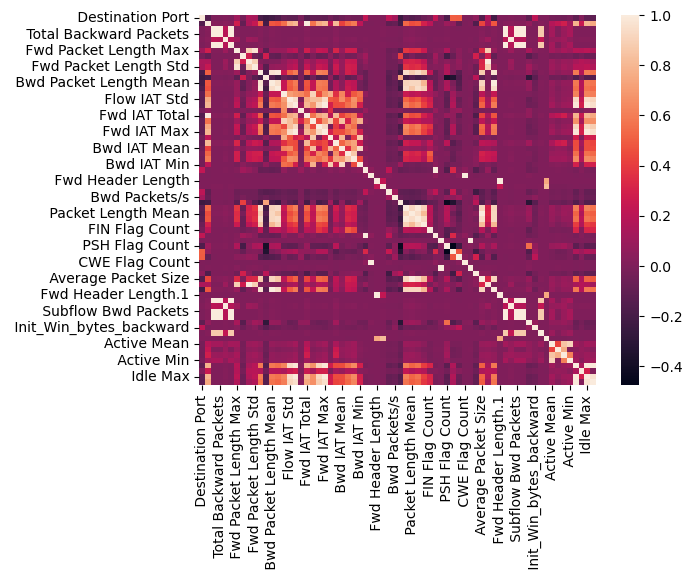

In [7]:
sns.heatmap(train_X.corr())

In [ ]:
del train_raw
model = RandomForestClassifier(n_estimators=200, n_jobs=n_cpu-1, random_state=seed)
kf = StratifiedKFold(shuffle=True, random_state=seed)
results = pd.DataFrame()

## Correlation-Based

In [5]:
correlation_matrix = train_X.corr()
selected_features = []

original_features = train_X.columns.tolist()
print(original_features)
start_time = time.time()
while len(original_features) > 0:
    indices = correlation_matrix[correlation_matrix.loc[:, original_features[0]] >= 0.8].index.tolist()
    indices = [i for i in indices if i in original_features]
    print(original_features[0], indices)
    if len(indices) == 1:
        selected_features.append(indices[0])
        original_features.remove(indices[0])
        continue

    selector = SelectFromModel(model, threshold=-np.inf, max_features=1)
    selector.fit(train_X[indices], train_Y)
    selected_features.append([b for a, b in zip(selector.get_support(), indices) if a][0])
    original_features = [col for col in original_features if col not in indices]

print(f'time cost: {time.time()-start_time}')
print(f'selected features: {selected_features}')

[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count', ' Down/Up Ratio', ' Avera

In [6]:
train_X = train_X[selected_features]
test_X = test_X[selected_features]
print(train_X.shape, test_X.shape)
n_features = train_X.shape[1]

(500000, 31) (500000, 31)


## Individual

In [10]:
start_time = time.time()
selector = SelectKBest(mutual_info_classif, k='all')
selector.fit(train_X, train_Y)
sorted_index = np.argsort(-selector.scores_)
mi_features = train_X.columns[sorted_index].tolist()
print('Univariate: ', mi_features)
print('Time cost: ', time.time()-start_time)

del selector

results['Univariate'] = mi_features
results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

Univariate:  [' Average Packet Size', ' Total Length of Bwd Packets', ' Destination Port', ' Subflow Fwd Bytes', 'Init_Win_bytes_forward', ' Init_Win_bytes_backward', ' Fwd Packet Length Max', ' Bwd Packets/s', ' Bwd Header Length', ' Fwd Header Length.1', 'Fwd Packets/s', 'Fwd IAT Total', ' Fwd IAT Mean', ' Bwd IAT Max', ' Bwd Packet Length Min', ' Fwd Packet Length Min', ' Min Packet Length', ' Bwd IAT Mean', ' Fwd IAT Std', ' Flow IAT Min', ' Active Max', ' PSH Flag Count', ' Down/Up Ratio', ' Idle Std', ' URG Flag Count', ' Active Std', ' ACK Flag Count', 'FIN Flag Count', ' SYN Flag Count', ' CWE Flag Count', ' ECE Flag Count']
Time cost:  94.04361081123352


In [12]:
start_time = time.time()
sfs_features = []
for i in trange(n_features-1):
    train_X2 = train_X.drop(sfs_features, axis=1)
    selector = SequentialFeatureSelector(model, n_features_to_select=train_X2.shape[1]-1, direction='backward', scoring='f1', cv=kf, n_jobs=n_cpu-1)
    selector.fit(train_X2, train_Y)
    f = train_X2.columns[~selector.get_support()][0]
    sfs_features.append(f)
    del train_X2

sfs_features.append(train_X.columns.drop(sfs_features)[0])
sfs_features.reverse()
print('SFS: ', sfs_features)
print('Time cost: ', time.time()-start_time)

del selector

results['SFS'] = sfs_features
results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [9:58:14<00:00, 1196.50s/it]  

SFS:  [' Average Packet Size', 'Init_Win_bytes_forward', ' Init_Win_bytes_backward', ' Destination Port', ' Flow IAT Min', ' Bwd IAT Max', 'Fwd Packets/s', ' Total Length of Bwd Packets', ' URG Flag Count', ' Down/Up Ratio', ' Fwd Packet Length Max', ' Idle Std', ' PSH Flag Count', ' Fwd Packet Length Min', ' Bwd Header Length', 'FIN Flag Count', ' CWE Flag Count', ' Bwd Packet Length Min', ' Min Packet Length', ' ACK Flag Count', ' Bwd IAT Mean', ' Active Max', ' ECE Flag Count', ' Fwd Header Length.1', ' Subflow Fwd Bytes', ' SYN Flag Count', ' Bwd Packets/s', ' Fwd IAT Std', ' Active Std', 'Fwd IAT Total', ' Fwd IAT Mean']
Time cost:  35894.95530319214


In [19]:
start_time = time.time()
selector = RFE(model, n_features_to_select=1)
selector.fit(train_X, train_Y)
sorted_index = np.argsort(selector.ranking_)
rfe_features = train_X.columns[sorted_index].tolist()
print('RFE: ', rfe_features)
print('Time cost: ', time.time()-start_time)

del selector
results['RFE'] = rfe_features
results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

RFE:  [' Average Packet Size', ' Init_Win_bytes_backward', 'Init_Win_bytes_forward', ' Fwd Packet Length Max', ' Destination Port', ' Subflow Fwd Bytes', ' Bwd Packet Length Min', ' Min Packet Length', ' Fwd IAT Std', ' Bwd Packets/s', ' Fwd IAT Mean', ' PSH Flag Count', 'Fwd IAT Total', ' Fwd Packet Length Min', 'Fwd Packets/s', ' Total Length of Bwd Packets', ' ACK Flag Count', ' Down/Up Ratio', ' Bwd IAT Max', ' Flow IAT Min', ' URG Flag Count', ' Bwd IAT Mean', ' Active Max', ' Active Std', 'FIN Flag Count', ' Idle Std', ' SYN Flag Count', ' Bwd Header Length', ' Fwd Header Length.1', ' CWE Flag Count', ' ECE Flag Count']
Time cost:  564.1302983760834


In [20]:
start_time = time.time()
model.fit(train_X, train_Y)
sorted_index = np.argsort(-model.feature_importances_)
imp_features = train_X.columns[sorted_index].tolist()
print('Importance: ', imp_features)
print('Time cost: ', time.time()-start_time)

results['Importance'] = imp_features
results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

Importance:  [' Average Packet Size', ' Destination Port', ' Init_Win_bytes_backward', ' Subflow Fwd Bytes', ' Fwd Packet Length Max', 'Init_Win_bytes_forward', ' Bwd Packet Length Min', ' Fwd IAT Std', ' Fwd IAT Mean', ' Min Packet Length', ' Bwd Packets/s', 'Fwd IAT Total', ' PSH Flag Count', ' Fwd Packet Length Min', ' ACK Flag Count', 'Fwd Packets/s', ' Total Length of Bwd Packets', ' Down/Up Ratio', ' Bwd IAT Max', ' URG Flag Count', ' Flow IAT Min', ' Bwd IAT Mean', ' Active Max', ' Active Std', 'FIN Flag Count', ' Idle Std', ' SYN Flag Count', ' Bwd Header Length', ' Fwd Header Length.1', ' CWE Flag Count', ' ECE Flag Count']
Time cost:  21.446688890457153


### Load from file

In [7]:
# results = pd.read_csv('./Experiments/IDS2017/results.csv')
# mi_features = results['Univariate'].to_list()
# sfs_features = results['SFS'].to_list()
# rfe_features = results['RFE'].to_list()
# imp_features = results['Importance'].to_list()

## Set

In [9]:
start_time = time.time()
union_features = []
intersection_features = []
quorum_features = []
n_features = train_X.shape[1]

for k in range(n_features):
    union_features.append(list(set().union(mi_features[:n_features-k], sfs_features[:n_features-k], rfe_features[:n_features-k], imp_features[:n_features-k])))
    intersection_features.append(list(set(mi_features[:n_features-k]).intersection(sfs_features[:n_features-k], rfe_features[:n_features-k], imp_features[:n_features-k])))
    quorum_features.append([f for f in train_X.columns if mi_features[:n_features-k].count(f)+sfs_features[:n_features-k].count(f)+rfe_features[:n_features-k].count(f)+imp_features[:n_features-k].count(f) > 2])
print('Union: ', [len(i) for i in union_features])
print('Intersection: ', [len(i) for i in intersection_features])
print('Quorum: ', [len(i) for i in quorum_features])
print('Time cost: ', time.time()-start_time)
union_features.reverse()
results['Union'] = union_features
intersection_features.reverse()
results['Intersection'] = intersection_features
quorum_features.reverse()
results['Quorum'] = quorum_features

results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

Union:  [31, 31, 31, 31, 31, 31, 30, 30, 29, 28, 28, 27, 27, 27, 26, 25, 24, 23, 22, 22, 19, 19, 17, 14, 11, 9, 8, 7, 5, 5, 1]
Intersection:  [31, 29, 27, 24, 21, 19, 18, 16, 16, 14, 12, 11, 11, 9, 8, 7, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 2, 1, 1, 1, 1]
Quorum:  [31, 30, 29, 28, 27, 26, 24, 23, 23, 22, 21, 20, 18, 16, 15, 14, 13, 11, 10, 7, 7, 6, 6, 6, 6, 5, 4, 3, 2, 1, 1]
Time cost:  0.002992391586303711


## Greedy

In [22]:
start_time = time.time()

greedy_features = []
univariate_features = mi_features.copy()

del selector

for i in trange(n_features-1):
    candidates = []
    scores = []

    train_X2 = train_X.drop(greedy_features, axis=1)

    f = univariate_features[0]
    candidates.append(f)
    cv = cross_val_score(model, train_X2.drop(f, axis=1), train_Y, scoring='f1', cv=kf, n_jobs=n_cpu-1)
    scores.append(cv.mean())

    selector = SequentialFeatureSelector(model, n_features_to_select=train_X2.shape[1]-1, direction='backward', scoring='f1', cv=kf, n_jobs=n_cpu-1)
    selector.fit(train_X2, train_Y)
    f = train_X2.columns[~selector.get_support()][0]
    candidates.append(f)
    cv = cross_val_score(model, train_X2.drop(f, axis=1), train_Y, scoring='f1', cv=kf)
    scores.append(cv.mean())

    del selector

    selector = RFE(model, n_features_to_select=train_X2.shape[1]-1)
    selector.fit(train_X2, train_Y)
    f = train_X2.columns[~selector.get_support()][0]
    candidates.append(f)
    cv = cross_val_score(model, train_X2.drop(f, axis=1), train_Y, scoring='f1', cv=kf, n_jobs=n_cpu-1)
    scores.append(cv.mean())

    del selector

    selector = SelectFromModel(model, threshold=-np.inf, max_features=train_X2.shape[1]-1)
    selector.fit(train_X2, train_Y)
    f = train_X2.columns[~selector.get_support()][0]
    candidates.append(f)
    cv = cross_val_score(model, train_X2.drop(f, axis=1), train_Y, scoring='f1', cv=kf, n_jobs=n_cpu-1)
    scores.append(cv.mean())

    del selector

    best_feature_index = np.argmin(scores)
    best_feature = candidates[best_feature_index]
    greedy_features.append(best_feature)
    univariate_features.remove(best_feature)

    del train_X2, candidates[:], scores[:]

greedy_features.append(train_X.columns.drop(greedy_features)[0])
greedy_features.reverse()
print('Time cost: ', time.time()-start_time)
print(f'greedy ordered feature: {greedy_features}')

results['Greedy'] = greedy_features
results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

100%|██████████| 30/30 [13:57:04<00:00, 1674.15s/it]  

Time cost:  50324.74154376984
greedy ordered feature: [' Average Packet Size', ' Init_Win_bytes_backward', 'Init_Win_bytes_forward', ' Fwd Packet Length Max', ' Destination Port', ' Subflow Fwd Bytes', ' Bwd Packets/s', 'Fwd Packets/s', ' Total Length of Bwd Packets', 'Fwd IAT Total', ' Fwd IAT Mean', ' Bwd Packet Length Min', ' Fwd Packet Length Min', ' Bwd IAT Max', ' Min Packet Length', ' Bwd IAT Mean', ' Fwd IAT Std', ' Flow IAT Min', ' PSH Flag Count', ' Down/Up Ratio', ' URG Flag Count', ' ACK Flag Count', ' Active Max', ' Active Std', ' Idle Std', ' Bwd Header Length', 'FIN Flag Count', ' Fwd Header Length.1', ' SYN Flag Count', ' CWE Flag Count', ' ECE Flag Count']


### Load from file

In [10]:
# greedy_features = results['Greedy'].to_list()

# Cross Validation / Test

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

tf.random.set_seed(seed)

def create_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Dense(50, activation='relu', input_shape=(input_shape,)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy)
    return model

In [23]:
def get_scores(model_name, feature_sets, feature_names):
    plt.subplots(2, 4)
    for k, (feature_set, feature_name) in enumerate(zip(feature_sets, feature_names)):
        cv_score = []
        test_score = []
        for i in trange(n_features):
            if isinstance(feature_set[0], list):
                train_X2 = train_X[feature_set[i]]
                test_X2 = test_X[feature_set[i]]
                if train_X2.empty:
                    cv_score.append(0)
                    test_score.append(0)
                    continue
            else:
                train_X2 = train_X[feature_set[:i+1]]
                test_X2 = test_X[feature_set[:i+1]]
            if k > 0 and train_X2.shape[1] == n_features:
                cv_score.append(results[f'cv_score_{feature_names[0]}_{model_name}'].iloc[-1])
                test_score.append(results[f'test_score_{feature_names[0]}_{model_name}'].iloc[-1])
                continue
            if model_name == 'NN':
                model = create_model(train_X2.shape[1])
                cv = []
                for train_index, test_index in kf.split(train_X2, train_Y):
                    x_train_fold, x_test_fold = train_X2.iloc[train_index, :], train_X2.iloc[test_index, :]
                    y_train_fold, y_test_fold = train_Y.iloc[train_index], train_Y.iloc[test_index]

                    model.fit(x_train_fold.values, y_train_fold.values,
                            epochs=15, batch_size=100, verbose=0)
                    
                    predict = model.predict(x_test_fold.values, verbose=0)
                    predict = np.where(predict < 0.5, 0, 1)
                    cv.append(f1_score(y_test_fold.values, predict))
            else:
                if model_name == 'LR':
                    model = LogisticRegression(C=100, solver='liblinear', random_state=seed, n_jobs=n_cpu-1)
                else:
                    model = GradientBoostingClassifier(n_estimators=200, random_state=seed)
                cv = cross_val_score(model, train_X2.values, train_Y.values, scoring='f1', cv=kf, n_jobs=n_cpu-1)
            cv_score.append(cv.mean())
            
            if model_name == 'NN':
                model.fit(train_X2.values, train_Y.values,
                epochs=15, batch_size=100, verbose=0)
                predict = model.predict(test_X2.values, verbose=0)
            else:
                model.fit(train_X2.values, train_Y.values)
                predict = model.predict(test_X2.values)
            test_score.append(f1_score(test_Y.values, predict))

            del train_X2
        results[f'cv_score_{feature_name}_{model_name}'] = cv_score
        results[f'test_score_{feature_name}_{model_name}'] = test_score
        results.to_csv(f'./Experiments/{dataset_name}/results.csv', index=False)

        plt.subplot(2, 4, k+1)
        plt.title(feature_name)
        plt.plot(range(n_features), cv_score, color='blue', linestyle='-', label='CV Score')
        plt.plot(range(n_features), test_score, color='red', linestyle='-', label='Test Score')

        del cv_score[:], test_score[:]
    plt.tight_layout()
    plt.show()

In [11]:
feature_sets = [mi_features, sfs_features, rfe_features, imp_features, union_features, intersection_features, quorum_features, greedy_features]
feature_names = ['Univariate', 'SFS', 'RFE', 'Importance', 'Union', 'Intersection', 'Quorum', 'Greedy']

## LR

100%|██████████| 31/31 [11:50<00:00, 22.91s/it]


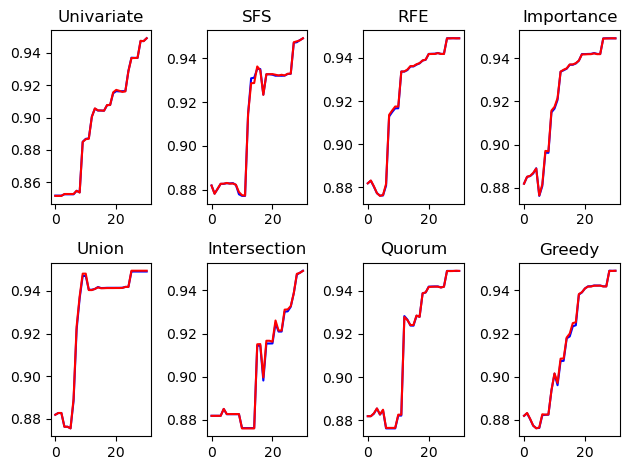

In [25]:
get_scores('LR', feature_sets, feature_names)

## GB

100%|██████████| 31/31 [3:08:41<00:00, 365.19s/it]  


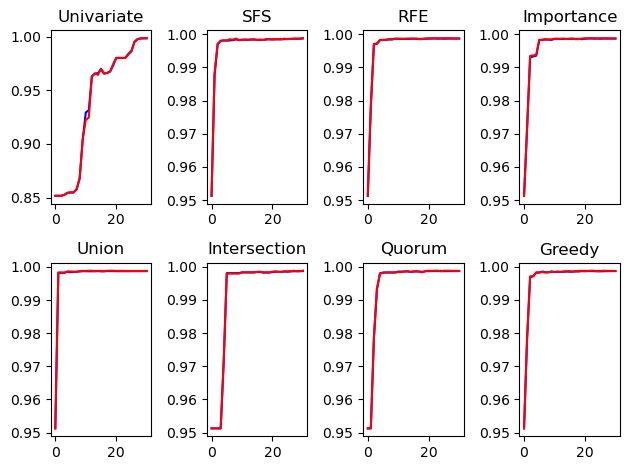

In [27]:
get_scores('GB', feature_sets, feature_names)

## NN

100%|██████████| 31/31 [13:04:36<00:00, 1518.59s/it]  


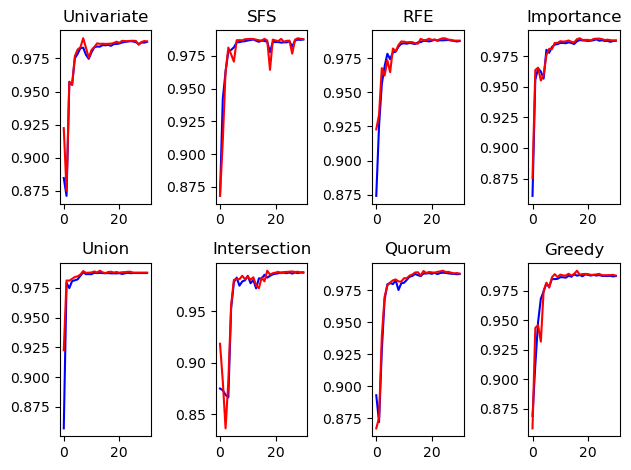

In [13]:
get_scores('NN', feature_sets, feature_names)

# Stopping Points

In [14]:
def MaxDelta(score):
    max_delta = 0
    index = len(score) - 1
    for i in range(len(score)-1, 0, -1):
        delta = score[i] - score[i-1]
        if delta > max_delta:
            max_delta = delta
            index = i

    return index

def MinPerfReq(score, tolerence):
    best_score = score[-1] * (1 - tolerence)
    index = len(score) - 1
    for i in range(len(score)-1, 0, -1):
        if score[i] < best_score:
            index = i+1
            break

    return index

def MaxScore(score, size, factor):
    best_performance = 0
    index = len(score) - 1
    for i in range(len(score)-1, 0, -1):
        current_size = size[i]
        adj_score = score[i] - (factor * current_size)
        if adj_score > best_performance:
            best_performance = adj_score
            index = i

    return index

In [15]:
tolerence = 0.03
factor = 0.03
stopping_points = {}
indices = []
for model_name in ['LR', 'GB', 'NN']:
    for feature_set, feature_name in zip(feature_sets, feature_names):
        cv_score = results[f'cv_score_{feature_name}_{model_name}'].to_list()
        test_score = results[f'test_score_{feature_name}_{model_name}'].to_list()
        if feature_name in ['Union', 'Intersection', 'Quorum']:
            subset_size = [len(i) for i in feature_set]
        else:
            subset_size = np.arange(1, n_features+1)
        stop1 = MaxDelta(cv_score)
        stop2 = MinPerfReq(cv_score, tolerence)
        stop3 = MaxScore(cv_score, subset_size, factor)

        for stop_name, index in zip(['MaxDelta', 'MinPerfReq', 'MaxScore'], [stop1, stop2, stop3]):
            stopping_points[f'{stop_name}_size_{feature_name}_{model_name}'] = subset_size[index]
            stopping_points[f'{stop_name}_cv_score_{feature_name}_{model_name}'] = cv_score[index]
            stopping_points[f'{stop_name}_test_score_{feature_name}_{model_name}'] = test_score[index]

stopping_points = pd.Series(stopping_points)
stopping_points

MaxDelta_size_Univariate_LR              10.000000
MaxDelta_cv_score_Univariate_LR           0.885017
MaxDelta_test_score_Univariate_LR         0.884923
MinPerfReq_size_Univariate_LR            25.000000
MinPerfReq_cv_score_Univariate_LR         0.928899
MinPerfReq_test_score_Univariate_LR       0.928621
MaxScore_size_Univariate_LR               2.000000
MaxScore_cv_score_Univariate_LR           0.851694
MaxScore_test_score_Univariate_LR         0.851524
MaxDelta_size_SFS_LR                     13.000000
MaxDelta_cv_score_SFS_LR                  0.914663
MaxDelta_test_score_SFS_LR                0.914698
MinPerfReq_size_SFS_LR                   14.000000
MinPerfReq_cv_score_SFS_LR                0.930879
MinPerfReq_test_score_SFS_LR              0.928625
MaxScore_size_SFS_LR                      2.000000
MaxScore_cv_score_SFS_LR                  0.878248
MaxScore_test_score_SFS_LR                0.878157
MaxDelta_size_RFE_LR                      8.000000
MaxDelta_cv_score_RFE_LR       

In [16]:
stopping_points.to_csv(f'./Experiments/{dataset_name}/stopping_points.csv', header=False)

# Visualization

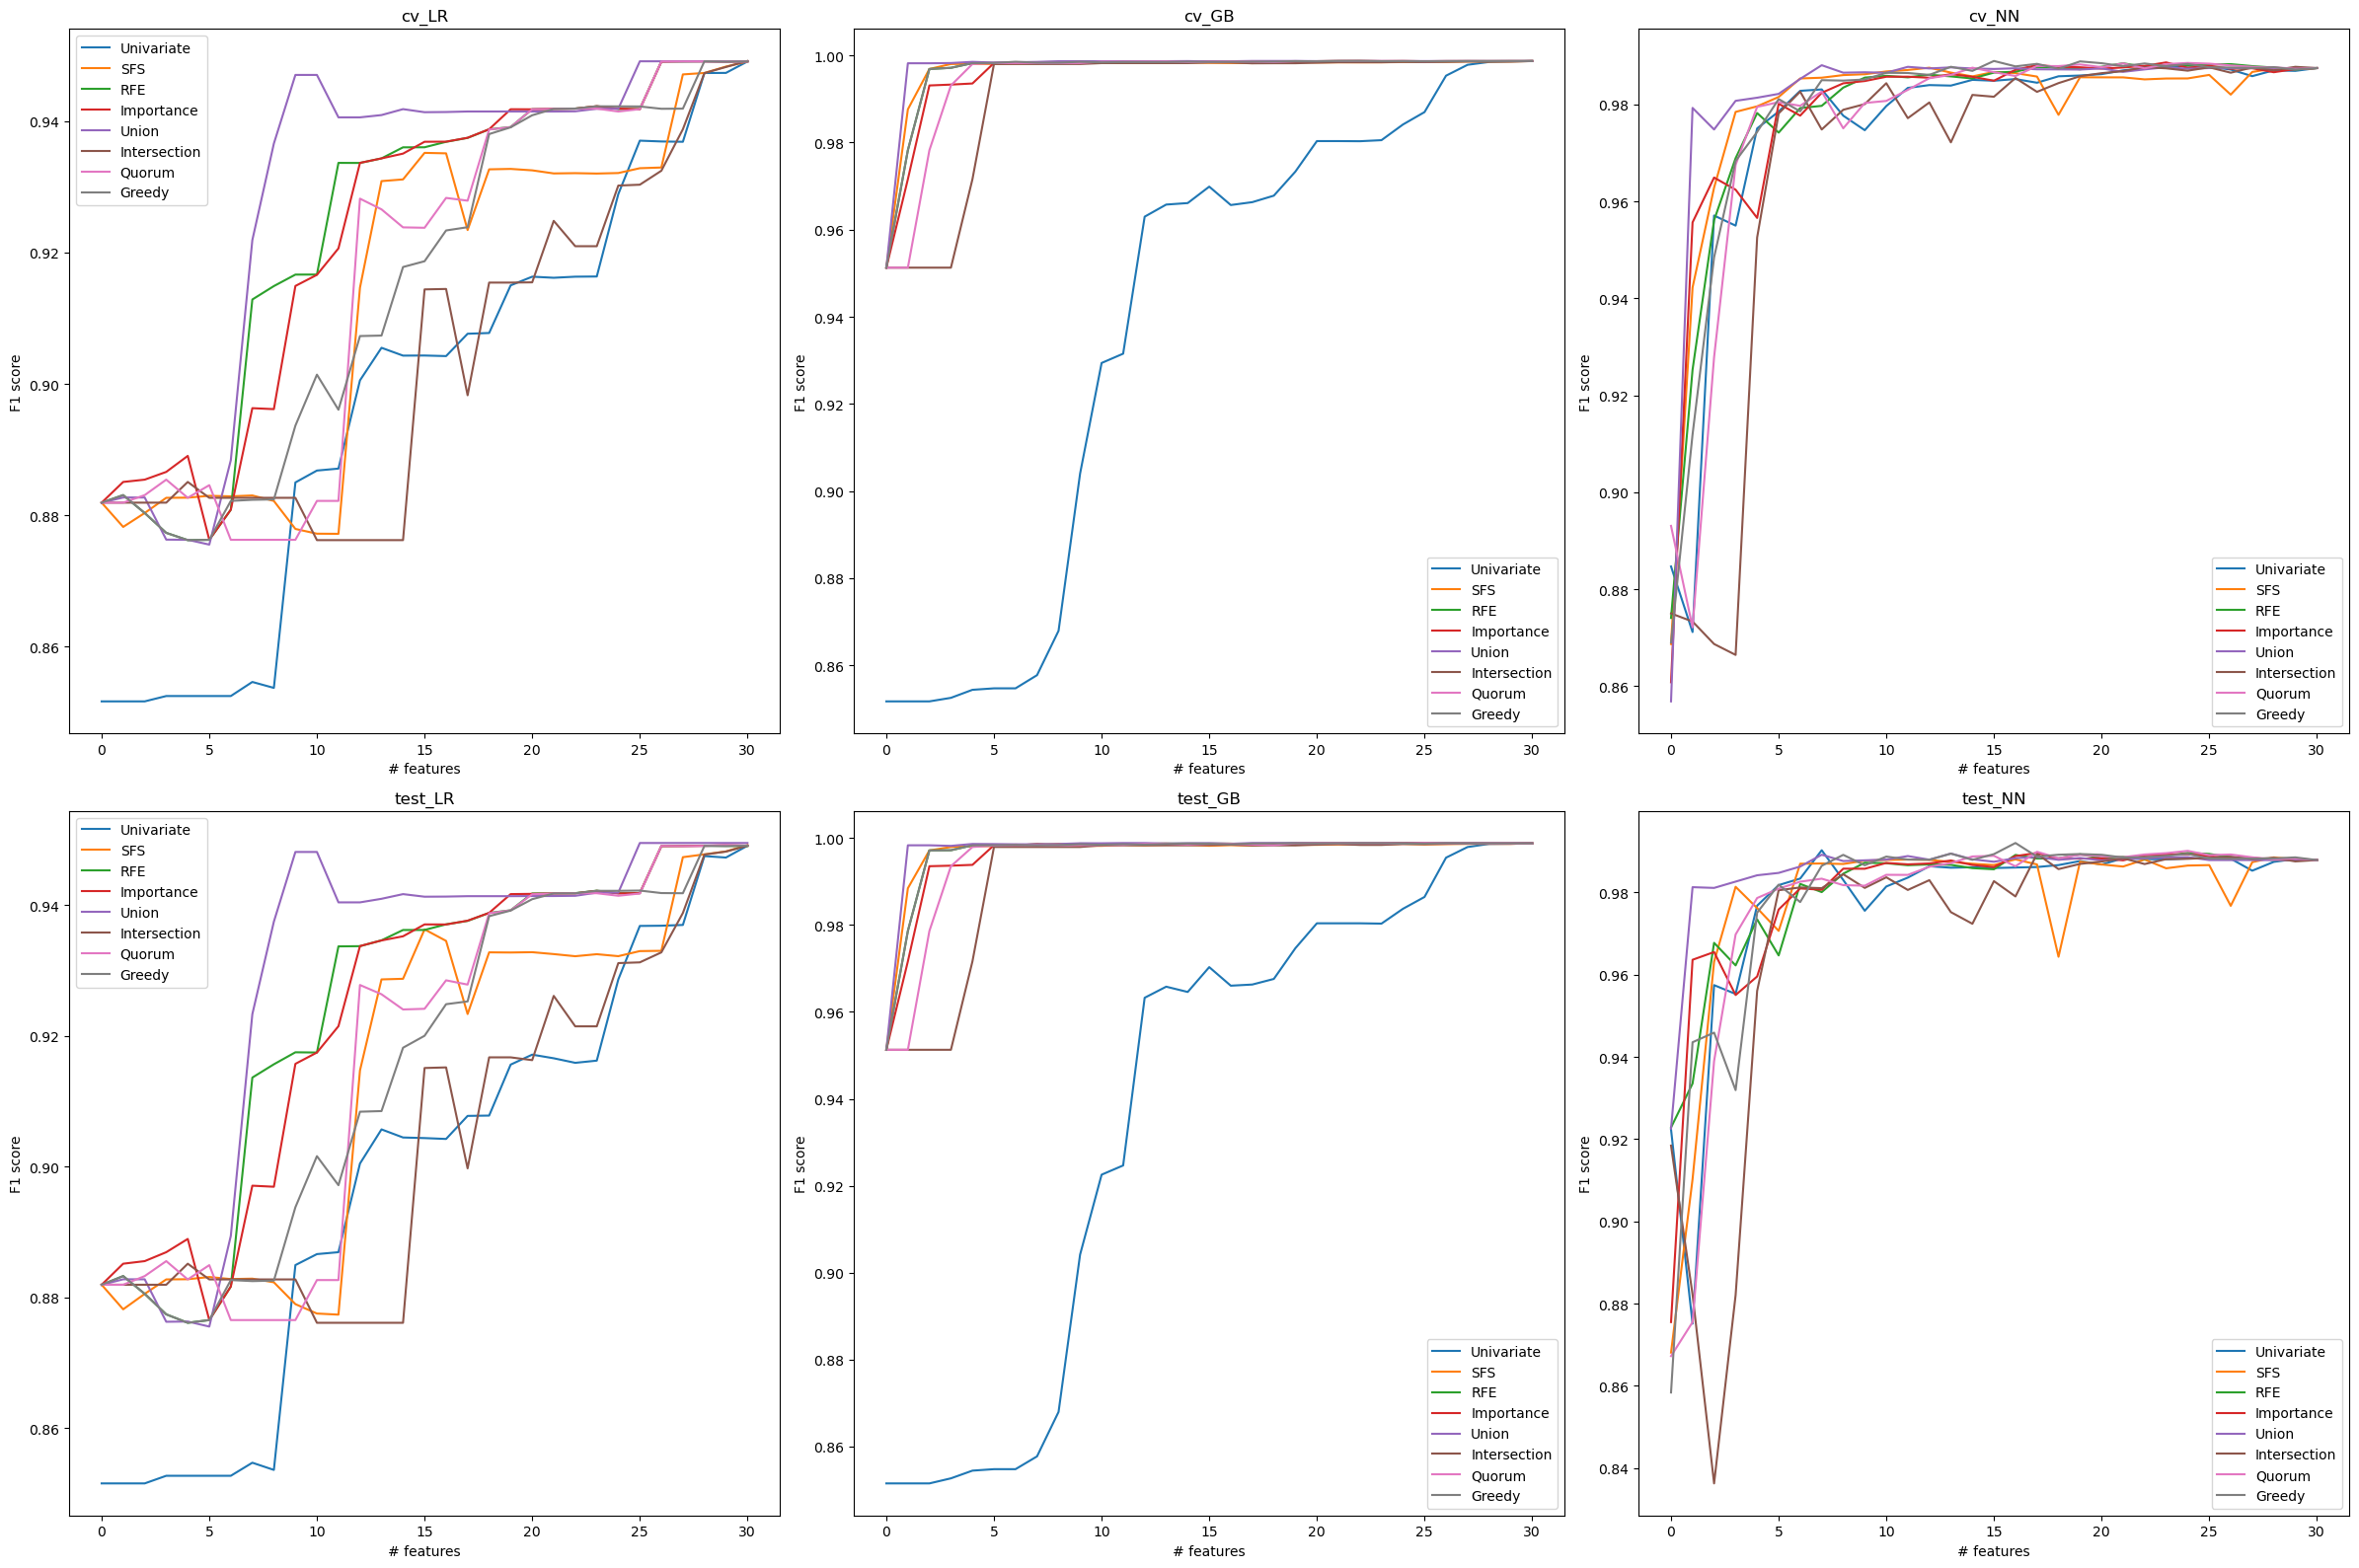

In [17]:
plt.subplots(2, 3, figsize=(24, 16))
for i, model_name in enumerate(['LR', 'GB', 'NN']):
    plt.subplot(2, 3, i+1)
    plt.title(f'cv_{model_name}')
    plt.xlabel('# features')
    plt.ylabel('F1 score')
    for feature_name in feature_names:
        plt.plot(range(n_features), results[f'cv_score_{feature_name}_{model_name}'], label=feature_name)
    plt.legend()
    plt.subplot(2, 3, i+4)
    plt.title(f'test_{model_name}')
    plt.xlabel('# features')
    plt.ylabel('F1 score')
    for feature_name in feature_names:
        plt.plot(range(n_features), results[f'test_score_{feature_name}_{model_name}'], label=feature_name)
    plt.legend()
plt.tight_layout()
plt.savefig(f'./Experiments/{dataset_name}/score_size.png')

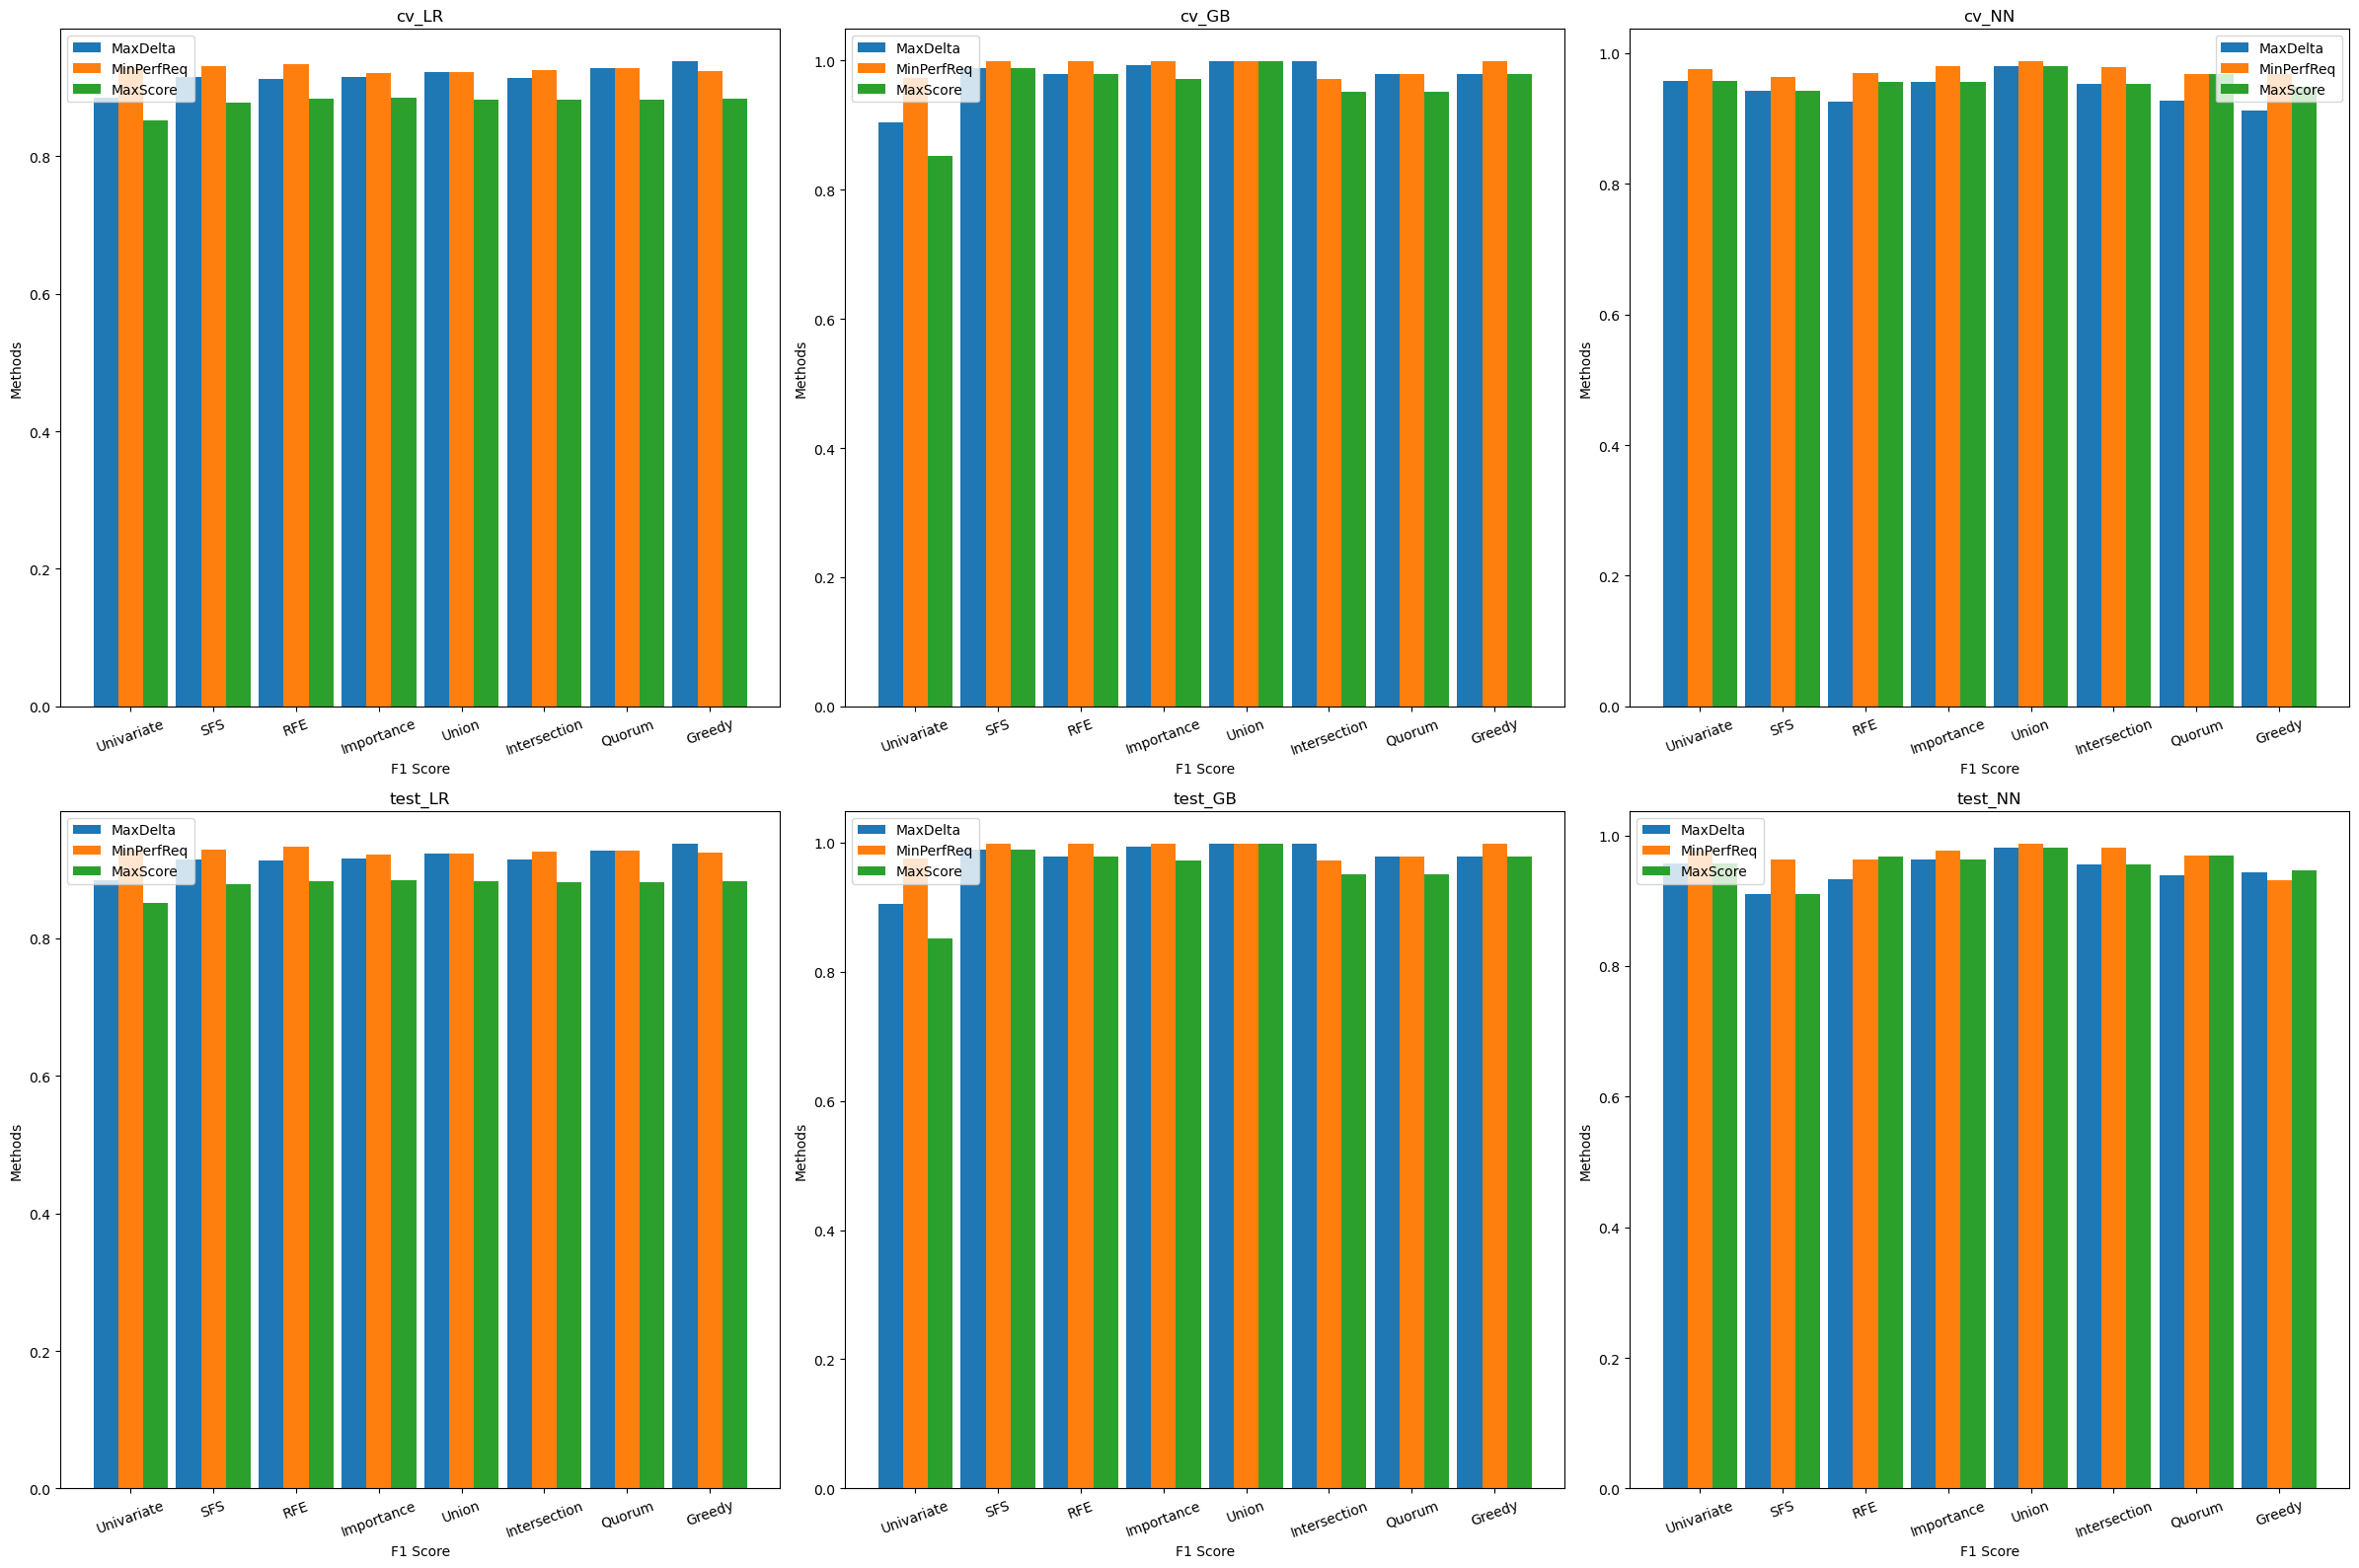

In [18]:
width=0.3
n = len(feature_names)
plt.subplots(2, 3, figsize=(24, 16))
for i, model_name in enumerate(['LR', 'GB', 'NN']):
    plt.subplot(2, 3, i+1)
    plt.title(f'cv_{model_name}')
    plt.xlabel('F1 Score')
    plt.ylabel('Methods')
    md = []
    mp = []
    ms = []
    for feature_name in feature_names:
        md.append(stopping_points[f'MaxDelta_cv_score_{feature_name}_{model_name}'])
        mp.append(stopping_points[f'MinPerfReq_cv_score_{feature_name}_{model_name}'])
        ms.append(stopping_points[f'MaxScore_cv_score_{feature_name}_{model_name}'])
    plt.bar(x=range(n), height=md, width=width, label='MaxDelta')
    plt.bar(x=[x+width for x in range(n)], height=mp, width=width, label='MinPerfReq')
    plt.bar(x=[x+width*2 for x in range(n)], height=ms, width=width, label='MaxScore')
    plt.xticks([x+width for x in range(n)], feature_names)
    plt.xticks(rotation=20)
    plt.legend()
    plt.subplot(2, 3, i+4)
    plt.title(f'test_{model_name}')
    plt.xlabel('F1 Score')
    plt.ylabel('Methods')
    md = []
    mp = []
    ms = []
    for feature_name in feature_names:
        md.append(stopping_points[f'MaxDelta_test_score_{feature_name}_{model_name}'])
        mp.append(stopping_points[f'MinPerfReq_test_score_{feature_name}_{model_name}'])
        ms.append(stopping_points[f'MaxScore_test_score_{feature_name}_{model_name}'])
    plt.bar(x=range(n), height=md, width=width, label='MaxDelta')
    plt.bar(x=[x+width for x in range(n)], height=mp, width=width, label='MinPerfReq')
    plt.bar(x=[x+width*2 for x in range(n)], height=ms, width=width, label='MaxScore')
    plt.xticks([x+width for x in range(n)], feature_names)
    plt.xticks(rotation=20)
    plt.legend()
plt.tight_layout()
plt.savefig(f'./Experiments/{dataset_name}/score_stop.png')

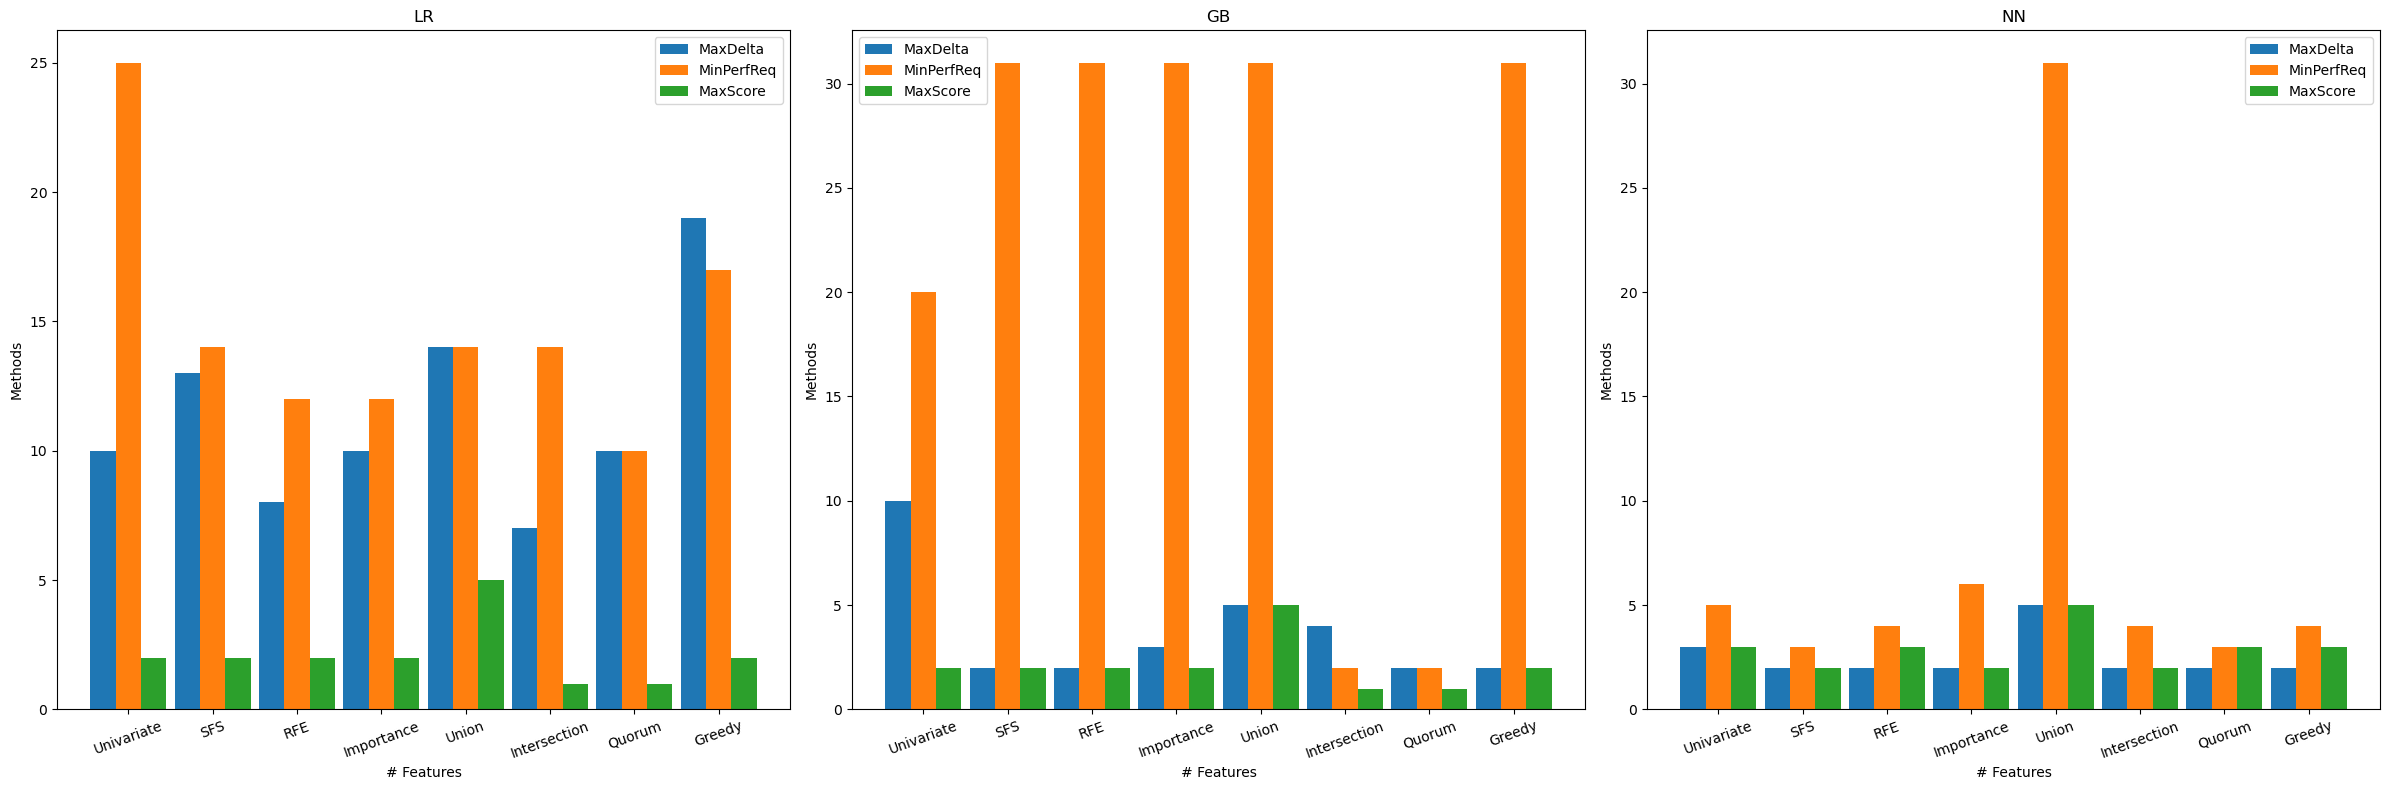

In [19]:
plt.subplots(1, 3, figsize=(24, 8))
for i, model_name in enumerate(['LR', 'GB', 'NN']):
    plt.subplot(1, 3, i+1)
    plt.title(f'{model_name}')
    plt.xlabel('# Features')
    plt.ylabel('Methods')
    md = []
    mp = []
    ms = []
    for feature_name in feature_names:
        md.append(stopping_points[f'MaxDelta_size_{feature_name}_{model_name}'])
        mp.append(stopping_points[f'MinPerfReq_size_{feature_name}_{model_name}'])
        ms.append(stopping_points[f'MaxScore_size_{feature_name}_{model_name}'])
    plt.bar(x=range(n), height=md, width=width, label='MaxDelta')
    plt.bar(x=[x+width for x in range(n)], height=mp, width=width, label='MinPerfReq')
    plt.bar(x=[x+width*2 for x in range(n)], height=ms, width=width, label='MaxScore')
    plt.xticks([x+width for x in range(n)], feature_names)
    plt.xticks(rotation=20)
    plt.legend()
plt.tight_layout()
plt.savefig(f'./Experiments/{dataset_name}/size_stop.png')